# 19.8 Predicting House Prices Challenge
The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

Steps:
    1. Load the houseprices data from Thinkful's database.
    2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
    3. Now, split your data into train and test sets where 20% of the data resides in the test set.
    4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
    5. Evaluate your best model on the test set.
    6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.
    
## Importing the Data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sqlalchemy import create_engine
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Data query
df = pd.read_sql_query('select * from houseprices', con=engine)
engine.dispose()

df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## Data Cleaning and Exploration

In [3]:
# SSee the data types and counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [4]:
# Counts of all the missing data
df.isna().sum()

id                  0
mssubclass          0
mszoning            0
lotfrontage       259
lotarea             0
street              0
alley            1369
lotshape            0
landcontour         0
utilities           0
lotconfig           0
landslope           0
neighborhood        0
condition1          0
condition2          0
bldgtype            0
housestyle          0
overallqual         0
overallcond         0
yearbuilt           0
yearremodadd        0
roofstyle           0
roofmatl            0
exterior1st         0
exterior2nd         0
masvnrtype          8
masvnrarea          8
exterqual           0
extercond           0
foundation          0
                 ... 
bedroomabvgr        0
kitchenabvgr        0
kitchenqual         0
totrmsabvgrd        0
functional          0
fireplaces          0
fireplacequ       690
garagetype         81
garageyrblt        81
garagefinish       81
garagecars          0
garagearea          0
garagequal         81
garagecond         81
paveddrive

### Dealing with Missing Data
Most of the missing variables are object types. Looking at the data description in https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data, the majority of the missing data is related to whether the houses have a pool, fence, or alleyway. As these items are important for the analysis and model they will be ignored.

### Data Exploration 
There are several questions posed when looking at the data set:
    1. What is the sales price of the house based on the condition? square footage? neighborhood?
    2. What is the timing of the sales in relation to the price? Are there certain years or months with higher prices?
    3. What are the correlation of the variables with the sales price of houses?
    
#### Sales Price Based on Condition
The minimum prices of the houses sold increases as the overall quality increases. The chart below shows that the overall trend of the house prices decrease as the overall condition increases. This is very surprising as one would expect the opposite. This could be related to the location of the houses as Ames, Iowa is home to Iwoa State University. Students, parents, and faculty members could be looking for houses in close proximity to campus and are willing to pay higher prices regardless of the house conditions.

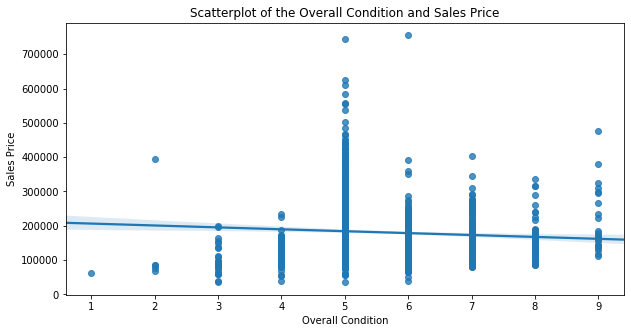

In [5]:
plt.figure(figsize=(10, 5))

# Plot the scatterplot of overall condition vs salesprice
sns.regplot(data=df, x='overallcond', y='saleprice')

plt.title('Scatterplot of the Overall Condition and Sales Price')
plt.xlabel('Overall Condition')
plt.ylabel('Sales Price')

plt.show()

#### House Prices Based on Neighborhood
As expected for the most part the housing prices are around the sub 200k price points. The violin plot below shows there are a few locations with house prices that are higher, but sales volume is low in those areas.

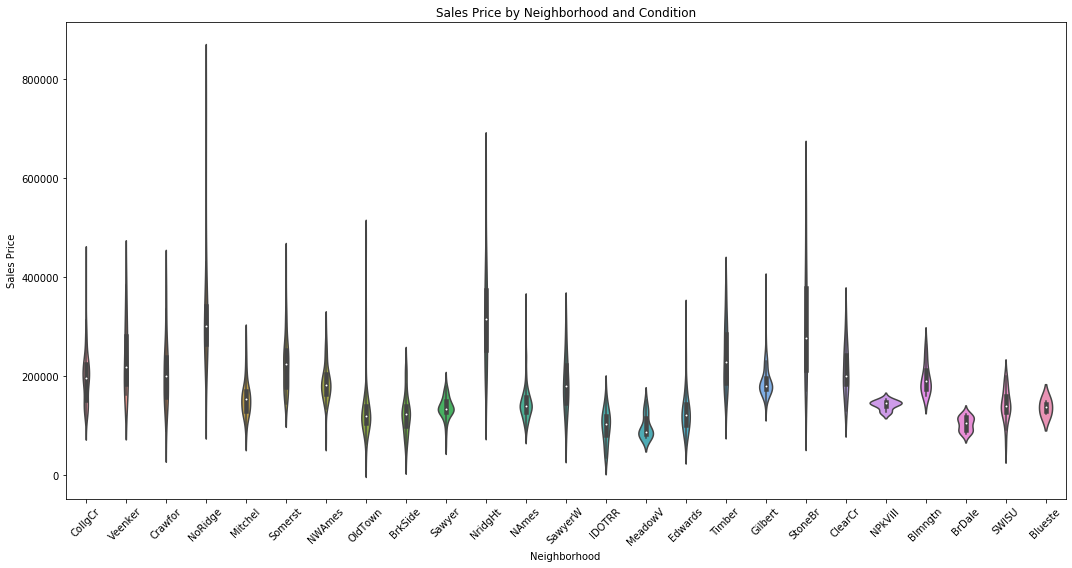

In [6]:
plt.figure(figsize=(15, 8))

# Plot salesprice per neighborhood
ax = sns.violinplot(data=df, x='neighborhood', y='saleprice')

plt.title('Sales Price by Neighborhood and Condition')
plt.ylabel('Sales Price')
plt.xlabel('Neighborhood')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# Below shows the average salesprice per neighborhood
df.groupby('neighborhood')['saleprice'].mean().sort_values(
    ascending=False)

neighborhood
NoRidge    335295.317073
NridgHt    316270.623377
StoneBr    310499.000000
Timber     242247.447368
Veenker    238772.727273
Somerst    225379.837209
ClearCr    212565.428571
Crawfor    210624.725490
CollgCr    197965.773333
Blmngtn    194870.882353
Gilbert    192854.506329
NWAmes     189050.068493
SawyerW    186555.796610
Mitchel    156270.122449
NAmes      145847.080000
NPkVill    142694.444444
SWISU      142591.360000
Blueste    137500.000000
Sawyer     136793.135135
OldTown    128225.300885
Edwards    128219.700000
BrkSide    124834.051724
BrDale     104493.750000
IDOTRR     100123.783784
MeadowV     98576.470588
Name: saleprice, dtype: float64

#### Sales Price per Square Footage
A new variable will be created with the data: total square footage. This variable will be the sum of square feet of the basement, first floor, second floor and garage living areas. The scatter plot below shows that there is a positive correlation between the square footage of the homes and the sales price. Furthermore it shows the linearity of the observations. 

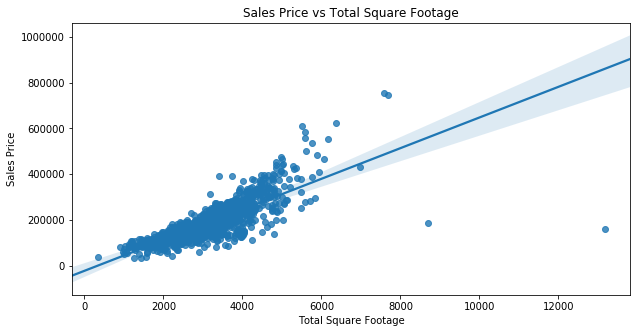

In [8]:
# Create new variable total_sqft from square footage variables
df['total_sqft'] =  df[['totalbsmtsf', 'firstflrsf', 
                        'secondflrsf', 'garagearea']].sum(axis=1)

plt.figure(figsize=(10, 5))

# Plot scatter plot of total sqft vs sales price
sns.regplot(data=df, x='total_sqft', y='saleprice')

plt.title('Sales Price vs Total Square Footage')
plt.ylabel('Sales Price')
plt.xlabel('Total Square Footage')

plt.show()

#### Sales Timing
The plots and figures below summarize two questions asked above: what is the timing in regards to sales and which years/ months have better sales. The first set of graphs helped understand the sales figures by year. According to the charts, the prices of the houses sold were higher in the years predating the 2008 recession. The year with the highest volume was in 2009 as many homeowners were trying to liqudate any assets because of the recession. 

The months with the highest numbers of sales are the summer months of May, June, and July. Afterwards, the sales taper off aggressively. What was surprising was the amount of sales that 2010 had or lack thereof. Less than 10 houses were sold in July 2010. The lack of sales could indicate that the owners with 'weak hands' sold their homes in 2009 during the recession. Another interesting point in the data is that the best time to buy a home is in April as the average house price  is at its lowest at 171k. This could be sales of homes listed in the winter or early purchases of the summer listings. 

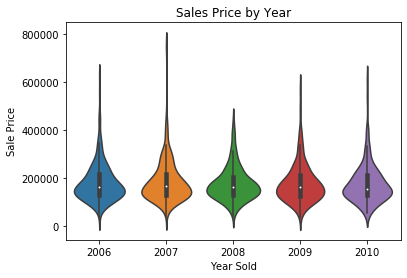

In [9]:
# Plot violin plot of th year sold and sale price
sns.violinplot(data=df, x='yrsold', y='saleprice')

plt.title('Sales Price by Year')
plt.ylabel('Sale Price')
plt.xlabel('Year Sold')

plt.show()

In [10]:
# What are the counts per year
df['yrsold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: yrsold, dtype: int64

In [11]:
round(df.groupby('yrsold')['saleprice'].mean(), 2)

yrsold
2006    182549.46
2007    186063.15
2008    177360.84
2009    179432.10
2010    177393.67
Name: saleprice, dtype: float64

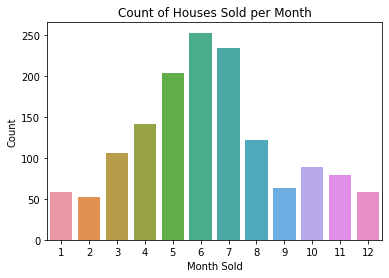

In [12]:
# plot bar chart of counts of homes sold in each month
sns.countplot(data=df, x='mosold')

plt.xlabel('Month Sold')
plt.ylabel('Count')
plt.title('Count of Houses Sold per Month')

plt.show()

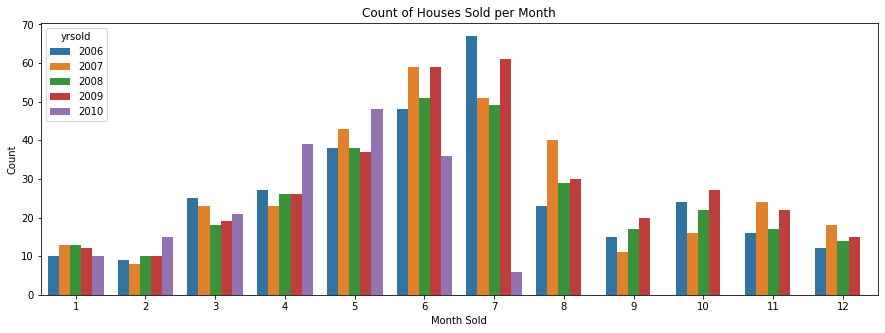

In [13]:
plt.figure(figsize=(15, 5))

# plot bar chart of counts of homes sold in each month split by years
sns.countplot(data=df, x='mosold', hue='yrsold')

plt.xlabel('Month Sold')
plt.ylabel('Count')
plt.title('Count of Houses Sold per Month')

plt.show()

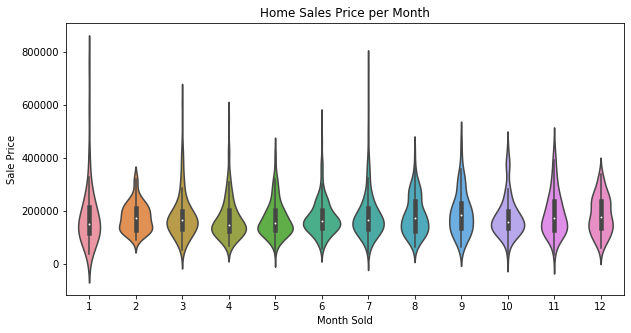

In [14]:
plt.figure(figsize=(10, 5))

# violin plot of monthsold and sales price
sns.violinplot(data=df, x='mosold', y='saleprice')

plt.xlabel('Month Sold')
plt.ylabel('Sale Price')
plt.title('Home Sales Price per Month')

plt.show()

In [15]:
# Average price of houses sold per month
round(df.groupby('mosold')['saleprice'].mean(), 2)

mosold
1     183256.26
2     177882.00
3     183253.92
4     171503.26
5     172307.27
6     177395.74
7     186331.19
8     184651.83
9     195683.21
10    179563.98
11    192210.91
12    186518.97
Name: saleprice, dtype: float64

#### Correlation

In [16]:
# Create correlation variable and print results
house_corr = df.corr().sort_values(by=['saleprice'],
                                   ascending=False)

print(house_corr['saleprice'])

saleprice        1.000000
total_sqft       0.809561
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr

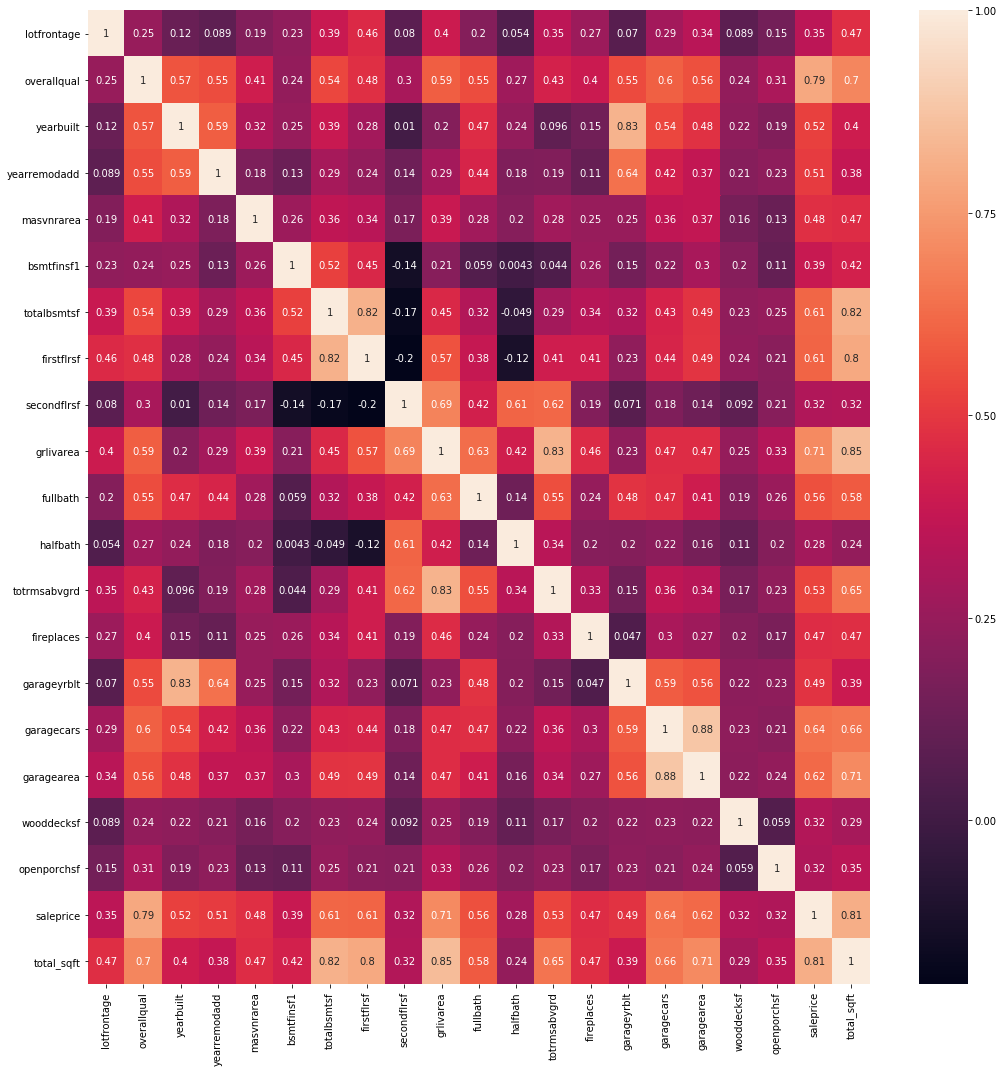

In [17]:
# Remove variables with low correlation <.25
df2 = df.drop(['id', 'mssubclass', 'overallcond', 'lotarea', 'bsmtfinsf2', 
                'bsmtunfsf', 'lowqualfinsf', 'bsmtfullbath', 'bsmthalfbath', 
                'bedroomabvgr','kitchenabvgr', 'enclosedporch', 'threessnporch', 
                'screenporch','poolarea', 'miscval', 'mosold', 'yrsold'], axis=1)

# Plot heatmap of remaining variables
plt.figure(figsize=(15,15))
sns.heatmap(df2.corr(), annot=True)
plt.tight_layout()
plt.show()

## Regression Model
A linear regression model will be fitted with the selected features. This model will then be improved over several iterations including ridge, lasso, and elasticnet regression. See below for more details over the model testing.

### Model 1
The variables chosen for the linear regression model will all be correlated to the sales price by over .6. Looking at the correlation of the values above the biggest indicators of sales price is overall quality, total basement square feet, first floor square feet, living area square feet, garage car capacity, garage square feet, and total_sqft.

In [18]:
# Target variable
Y = df['saleprice']

# Regression features
X = df[['overallqual', 'totalbsmtsf', 'firstflrsf', 'grlivarea',
      'garagecars', 'garagearea', 'total_sqft']]

# Split the data between train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
        test_size=0.2, random_state=145)

# Add constant
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()

# Print training data results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     496.6
Date:                Mon, 26 Aug 2019   Prob (F-statistic):               0.00
Time:                        18:09:54   Log-Likelihood:                -14002.
No. Observations:                1168   AIC:                         2.802e+04
Df Residuals:                    1160   BIC:                         2.806e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.876e+04   5573.649    -17.718      0.000    -1.1e+05   -8.78e+04
overallqual  2.434e+04   1204.363     20.212      0.000     2.2e+04    2.67e+04
totalbsmtsf   -25.5671     24.325     -1.051      0.293     -73.293      22.159
firstflrsf      8.7434      5.527      1.582      0.114      -2.101      19.588
grlivarea      -2.5526     23.307     -0.110      0.913     -48.282      43.177
garagecars   1.445e+04   3502.781      4.125      0.000    7577.823    2.13e+04
garagearea    -26.6015     26.763     -0.994      0.320     -79.112      25.909
total_sqft     45.3936     23.887      1.900      0.058      -1.474      92.261
==============================================================================
Omnibus:                      344.948   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28547.942
Skew:                          -0.324   Prob(JB):                         0.00
Kurtosis:                      27.211   Cond. No.                     1.95e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared of training set: 0.7498006751797821
-----Test set statistics-----
R-squared of test set: 0.8009436712215483
MAE: 24723.21702956409
MSE: 1461472946.0750623
RMSE: 38229.21587052319
MAPE: 14.472012549122972


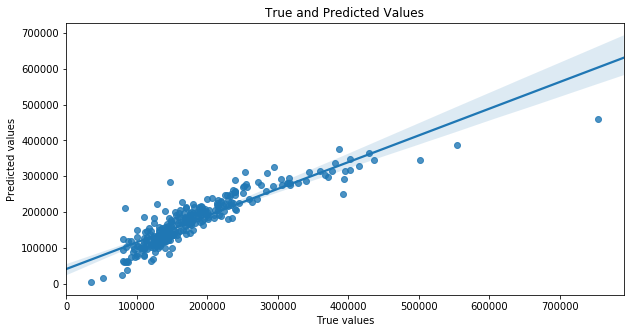

In [19]:
# Add constant to test data and predict results
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)

# Used to calculate the R-squared for comparison
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# Print comparative statistics
print("R-squared of training set: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of test set: {}".format(lrm.score(X_test, Y_test)))
print('MAE: {}'.format(mean_absolute_error(Y_test, y_pred)))
print('MSE: {}'.format(mse(Y_test, y_pred)))
print('RMSE: {}'.format(rmse(Y_test, y_pred)))
print('MAPE: {}'.format(np.mean(np.abs((Y_test-y_pred)/Y_test))*100))

# Plot a Regplot of the True values vs Predicted
plt.figure(figsize=(10,5))
sns.regplot(x=Y_test, y=y_pred)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and Predicted Values")
plt.show()

### Model 2
The first linear regression model had a strong goodness of fit as the adjusted r-squared variable in the training set is .748. The test set had a r-squared value of .80, which is means the model could be overfitted due to the large generalization gap. There are several issues that need to be fixed before the generalization gap can be addressed. First 'grlivarea' variable is not significant as the p-value is greater that .05. Another issue is variable total_sqft. The square footage variables were summed into total_sqft these variables are essentially biasing the model and will be removed. 

In [20]:
# Target variable
Y = df['saleprice']

# Regression features
X = df[['overallqual', 'garagecars', 'total_sqft']]

# Split the data into train and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
        test_size=0.2, random_state=145)

# Add constant
X_train = sm.add_constant(X_train)

# Print results of second model
results = sm.OLS(Y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     1133.
Date:                Mon, 26 Aug 2019   Prob (F-statistic):               0.00
Time:                        18:09:55   Log-Likelihood:                -14013.
No. Observations:                1168   AIC:                         2.803e+04
Df Residuals:                    1164   BIC:                         2.805e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.431e+04   5277.934    -17.869      0.000   -1.05e+05    -8.4e+04
overallqual  2.437e+04   1196.686     20.367      0.000     2.2e+04    2.67e+04
garagecars   1.111e+04   2113.225      5.257      0.000    6962.811    1.53e+04
total_sqft     34.8989      1.818     19.194      0.000      31.331      38.466
==============================================================================
Omnibus:                      370.252   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35881.685
Skew:                          -0.412   Prob(JB):                         0.00
Kurtosis:                      30.141   Cond. No.                     1.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared of training set: 0.7449288854414906
-----Test set statistics-----
R-squared of test set: 0.800937907666266
MAE: 24323.094228199905
MSE: 1461515262.1376886
RMSE: 38229.76931839491
MAPE: 14.185730468470947


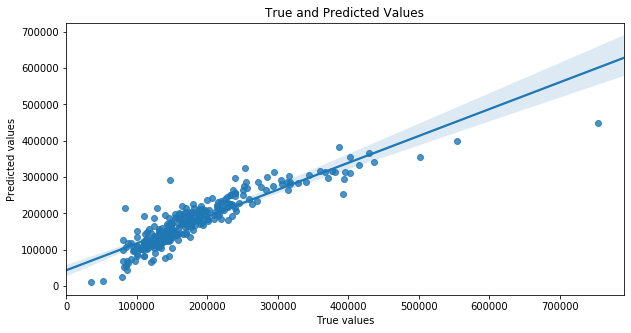

In [21]:
# Add constant to test data and predict results
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)

# Used to calculate the R-squared for comparison
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# Print comparative statistics
print("R-squared of training set: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of test set: {}".format(lrm.score(X_test, Y_test)))
print('MAE: {}'.format(mean_absolute_error(Y_test, y_pred)))
print('MSE: {}'.format(mse(Y_test, y_pred)))
print('RMSE: {}'.format(rmse(Y_test, y_pred)))
print('MAPE: {}'.format(np.mean(np.abs((Y_test-y_pred)/Y_test))*100))

# Plot a Regplot of the True values vs Predicted
plt.figure(figsize=(10,5))
sns.regplot(x=Y_test, y=y_pred)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and Predicted Values")
plt.show()

### Model 3
Surprisingly, the data performed worse than the initial model in both the training and test sets. The model could be skewed due to outliers in the variables. The variables in the model was plotted below. There were several outliers in both the saleprice and the total_sqft. These items were log transformed in other to remove the outliers and skew. 

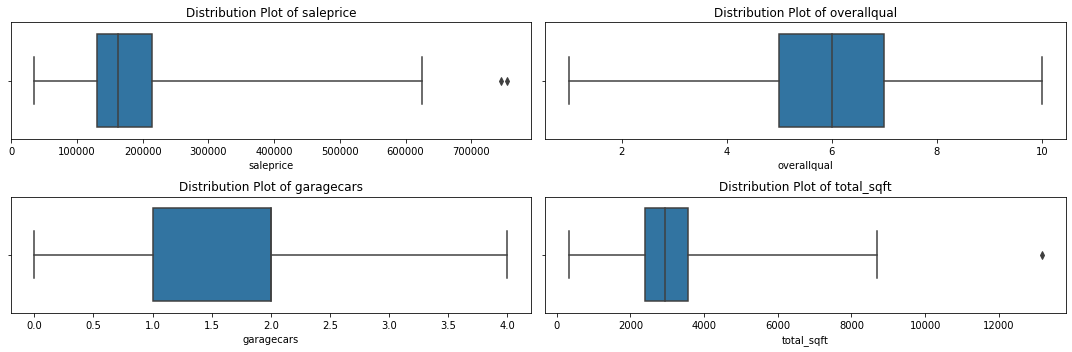

In [22]:
# Create list for the for loop
variables = ['saleprice', 'overallqual', 
               'garagecars', 'total_sqft']

plt.figure(figsize=(15,5))

# Plot boxplot for each variable
for i, variable in enumerate(variables):
    i += 1
    plt.subplot(2, 2, i)
    sns.boxplot(df[variable], whis=5)
    plt.title('Distribution Plot of {}'.format(variable))

plt.tight_layout()
plt.show()

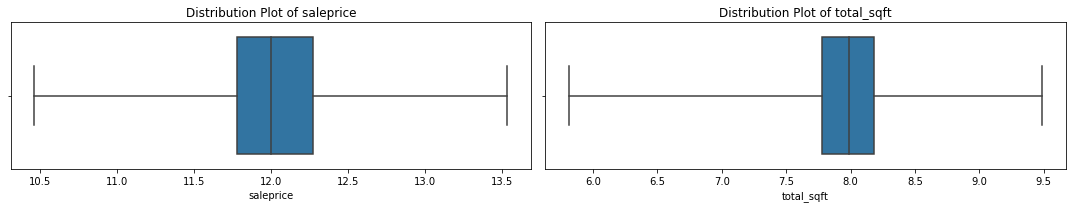

In [23]:
# Create list of skewed variables
skewed_variables = ['saleprice', 'total_sqft']

# Log transform the variables
df[skewed_variables] = np.log1p(df[skewed_variables])

# Plot the skewed variables to check outliers
plt.figure(figsize=(15,3))
for i, variable in enumerate(skewed_variables):
    i += 1
    plt.subplot(1, 2, i)
    sns.boxplot(df[variable], whis=5)
    plt.title('Distribution Plot of {}'.format(variable))

plt.tight_layout()
plt.show()

In [24]:
# Target variable
Y = df['saleprice']

# Regression features
X = df[['overallqual', 'garagecars', 'total_sqft']]

# Split the data between train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
        test_size=0.2, random_state=145)

# Add constant
X_train = sm.add_constant(X_train)

# Print results of third model
results = sm.OLS(Y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1557.
Date:                Mon, 26 Aug 2019   Prob (F-statistic):               0.00
Time:                        18:09:56   Log-Likelihood:                 360.16
No. Observations:                1168   AIC:                            -712.3
Df Residuals:                    1164   BIC:                            -692.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.5823      0.184     35.780      0.000       6.221       6.943
overallqual     0.1267      0.005     23.493      0.000       0.116       0.137
garagecars      0.0584      0.010      5.921      0.000       0.039       0.078
total_sqft      0.5723      0.026     22.064      0.000       0.521       0.623
==============================================================================
Omnibus:                      352.663   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2285.621
Skew:                          -1.231   Prob(JB):                         0.00
Kurtosis:                       9.396   Cond. No.                         368.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared of training set: 0.800520443803896
-----Test set statistics-----
R-squared of test set: 0.8450792191043559
MAE: 21108.608450254305
MSE: 1115537994.1130955
RMSE: 33399.6705689307
MAPE: 11.76089259094637


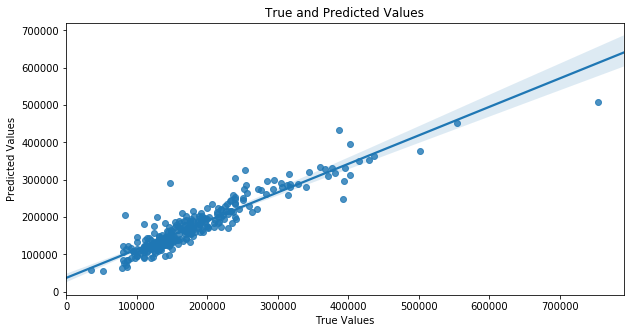

In [25]:
# Add constant and predict results
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)

# Used for comparison below
lrm = LinearRegression()
lrm.fit(X_train, Y_train)

# Print comparison
print("R-squared of training set: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of test set: {}".format(lrm.score(X_test, Y_test)))

# Compute exponential on test and predicted data 
# for comparison between models
y_pred = np.expm1(y_pred)
Y_test = np.expm1(Y_test)

print('MAE: {}'.format(mean_absolute_error(Y_test, y_pred)))
print('MSE: {}'.format(mse(Y_test, y_pred)))
print('RMSE: {}'.format(rmse(Y_test, y_pred)))
print('MAPE: {}'.format(np.mean(np.abs((Y_test-y_pred)/Y_test))*100))

# Plot regplot of test and predicted values
plt.figure(figsize=(10,5))
sns.regplot(x=Y_test, y=y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True and Predicted Values")
plt.show()

### Evaluating the Last Model Performance
The model that removed the insignificant variables and transformed the data performed the best. The r-squared values of the test sets increased by .044 indicating a stronger goodness of fit. All the variables p-values are below .05, which means they are all significant. Unfortunately, the generalization gap is still fairly large. To fix this issue Ridge, Lasso, and ElasticNet will be applied to the the latest model. 

## Ridge, Lasso, ElasticNet
The ridge, lasso, and elasticnet models did not out perform the third model. Out of the three, the best model was the **Lasso** in terms of reducing the generalization gap. The r-squared for the test data was .8450, and the MAE, MSE, RMSE, and MAPE were all barely higher.

### Ridge Regression

In [26]:
# Target variable
Y = df['saleprice']

# Regression features
X = df[['overallqual', 'garagecars', 'total_sqft']]

# Split the data between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y,
        test_size=0.2, random_state=145)

# Create list of alpha values for the regressions
alpha_values = [np.power(10.0, p) for p in np.arange(-10, 50, 1)]

In [27]:
# Create ridge model and fit train data
ridge = RidgeCV(alphas=alpha_values, cv=5)
ridge.fit(X_train, y_train)

# Make predictions of train and test data
y_preds_train = ridge.predict(X_train)
y_preds_test = ridge.predict(X_test)

# Print statistics
print("Best alpha value is: {}".format(ridge.alpha_))
print("R-squared of training set: {}".format(
    ridge.score(X_train, y_train)))

print("-----Test set statistics-----")
print("R-squared of test set: {}".format(
    ridge.score(X_test, y_test)))

# Compute exponential on test and predicted data 
# for comparison between models
y_test = np.expm1(y_test)
y_preds_test = np.expm1(y_preds_test)

print("MAE: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("MSE: {}".format(mse(y_test, y_preds_test)))
print("RMSE: {}".format(rmse(y_test, y_preds_test)))
print("MAPE: {}".format(np.mean(np.abs((
    y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.1
R-squared of training set: 0.8005200992614179
-----Test set statistics-----
R-squared of test set: 0.8450286028869232
MAE: 21113.114462326852
MSE: 1116359141.5229788
RMSE: 33411.96105473276
MAPE: 11.762483111831806


### Lasso Regression

In [28]:
# Split the data between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y,
        test_size=0.2, random_state=145)

# Create lasso model and fit train data
lasso = LassoCV(alphas=alpha_values, cv=5)
lasso.fit(X_train, y_train)

# Make predictions of train and test data
y_preds_train = lasso.predict(X_train)
y_preds_test = lasso.predict(X_test)

# Print statistics
print("Best alpha value is: {}".format(lasso.alpha_))
print("R-squared of training set: {}".format(
    lasso.score(X_train, y_train)))

print("-----Test set statistics-----")
print("R-squared of test set: {}".format(
    lasso.score(X_test, y_test)))

# Compute exponential on test and predicted data 
# for comparison between models
y_test = np.expm1(y_test)
y_preds_test = np.expm1(y_preds_test)

print("MAE: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("MSE: {}".format(mse(y_test, y_preds_test)))
print("RMSE: {}".format(rmse(y_test, y_preds_test)))
print("MAPE: {}".format(np.mean(np.abs((
    y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of training set: 0.8005195202628043
-----Test set statistics-----
R-squared of test set: 0.845004089788745
MAE: 21116.823230240872
MSE: 1117214321.061904
RMSE: 33424.75611073182
MAPE: 11.762945935906835


### ElasticNet Regression

In [29]:
# Split the data between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y,
        test_size=0.2, random_state=145)

# Create elasticnet model and fit train data
elasticnet = ElasticNetCV(alphas=alpha_values, cv=5)
elasticnet.fit(X_train, y_train)

# Make predictions of train and test data
y_preds_train = elasticnet.predict(X_train)
y_preds_test = elasticnet.predict(X_test)

# Print statistics
print("Best alpha value is: {}".format(elasticnet.alpha_))
print("R-squared of training set: {}".format(
    elasticnet.score(X_train, y_train)))

print("-----Test set statistics-----")
print("R-squared of test set: {}".format(
    elasticnet.score(X_test, y_test)))

# Compute exponential on test and predicted data 
# for comparison between models
y_test = np.expm1(y_test)
y_preds_test = np.expm1(y_preds_test)

print("MAE: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("MSE: {}".format(mse(y_test, y_preds_test)))
print("RMSE: {}".format(rmse(y_test, y_preds_test)))
print("MAPE: {}".format(np.mean(np.abs((
    y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of training set: 0.8005197846565079
-----Test set statistics-----
R-squared of test set: 0.845012033473
MAE: 21115.28390489252
MSE: 1116854244.6861289
RMSE: 33419.369304134525
MAPE: 11.762827166048343


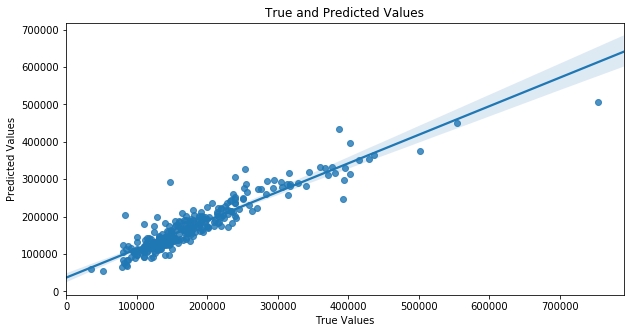

In [30]:
# Plot regplot of test and predicted values
plt.figure(figsize=(10,5))
sns.regplot(x=Y_test, y=y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True and Predicted Values")
plt.show()

## External Factors
There are hundreds of different factors that could affect the house prices outside of the internal variables in the data collected in this data frame. Some of these external variables are mortgage interest rates, the overall US economy, or even regional trends. The following variables will be combined into the model and the results will be analyzed. The variables are the following:
    1. Historic Mortgage Interest Rates
    2. Unemployment Rate
    3. Consumer Sentiment
    4. Tuition

Note the home sales of Ames, Iowa is the source of the data. Ames, Iowa is a college town; Home to Iowa State University. This could imply that tuition could be a factor in housing prices ie. cheaper tuition could have increased enrollment and home sales. The other key take away from the location is that half of the population of the town is from out of state. The national averages would be a better indicator rather than the Iowa in-state variables

### Importing the External Sources

In [31]:
mortgage = pd.read_csv('mortgage interest rates.csv')

# Drop empty columns
mortgage.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], 
              axis=1, inplace=True)

mortgage

,Year,Lowest Rate,Highest Rate,Average Rate
0,2010,0.0417,0.0521,0.0469
1,2009,0.0471,0.0559,0.0504
2,2008,0.0510,0.0663,0.0603
3,2007,0.0596,0.0674,0.0634
4,2006,0.0610,0.0680,0.0641


In [32]:
unemploy = pd.read_csv('unemployment.csv')
unemploy.head()

,Area,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,United States,7.1,7.6,9.7,9.6,7.5,7.2,7.0,6.2,5.5,...,4.6,4.6,5.8,9.3,9.6,8.9,8.1,7.4,6.2,5.3
1,Alabama,8.9,10.6,14.1,13.8,11.0,9.2,9.7,8.1,7.2,...,4.0,4.0,5.7,11.0,10.5,9.6,8.0,7.2,6.8,6.1
2,Alaska,9.6,9.4,9.9,9.9,9.8,9.7,10.9,10.3,8.8,...,6.6,6.3,6.7,7.7,7.9,7.6,7.1,6.9,6.9,6.5
3,Arizona,6.6,6.2,10.1,8.8,5.2,6.3,6.9,6.5,6.4,...,4.2,3.9,6.2,9.9,10.4,9.5,8.3,7.7,6.8,6.1
4,Arkansas,7.6,8.7,9.9,9.9,8.7,8.7,8.6,8.1,7.6,...,5.2,5.3,5.5,7.8,8.2,8.3,7.6,7.3,6.1,5.2


In [33]:
# Transpose the dataframe so year is its own column
unemploy = unemploy.set_index('Area').T

# Reset the index so the index is not the years
unemploy.reset_index(inplace=True)

# Rename index column to Year
unemploy.rename(columns={'index': 'Year'}, inplace=True)

# Convert from object to int
unemploy['Year'] = unemploy['Year'].astype(str).astype(float)

unemploy.head()

Area,Year,United States,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1980.0,7.1,8.9,9.6,6.6,7.6,6.8,5.8,5.8,7.6,...,4.8,7.4,5.1,6.2,6.2,5.2,8.1,9.5,7.2,3.9
1,1981.0,7.6,10.6,9.4,6.2,8.7,7.4,5.7,6.2,7.8,...,5.0,9.0,5.3,6.6,5.8,6.0,9.6,10.6,8.0,4.1
2,1982.0,9.7,14.1,9.9,10.1,9.9,10.0,7.3,6.9,8.4,...,5.5,11.7,6.9,8.2,7.0,7.4,11.9,14.0,10.5,6.2
3,1983.0,9.6,13.8,9.9,8.8,9.9,9.8,7.1,6.0,7.7,...,5.2,11.5,7.9,8.7,6.4,6.4,11.1,17.8,10.2,8.2
4,1984.0,7.5,11.0,9.8,5.2,8.7,7.8,5.4,4.7,6.3,...,4.4,8.5,6.1,6.5,5.1,5.1,9.3,14.8,7.4,6.3


In [34]:
consumer = pd.read_csv('consumer sentiment.csv')

# Drop empty columns
consumer.drop('Unnamed: 2', axis=1, inplace=True)
consumer

,Year,Consumer Sentiment
0,2006,87.3
1,2007,85.6
2,2008,63.8
3,2009,66.3
4,2010,71.8


In [35]:
tuition = pd.read_csv('tuition.csv')
tuition

,Year,In-State,Out-of-State
0,2006,7257,20252
1,2007,7454,20469
2,2008,7286,19877
3,2009,7783,20913
4,2010,8088,21458


### Appending Rates to Dataframe

In [36]:
# Add new variable based on year sold
df['mortgage'] = df['yrsold'].map(mortgage.set_index('Year')['Average Rate'])
df['unemploy'] = df['yrsold'].map(unemploy.set_index('Year')['United States'])
df['consumer'] = df['yrsold'].map(consumer.set_index('Year')['Consumer Sentiment'])
df['in_state'] = df['yrsold'].map(tuition.set_index('Year')['In-State'])
df['out_state'] = df['yrsold'].map(tuition.set_index('Year')['Out-of-State'])

df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,yrsold,saletype,salecondition,saleprice,total_sqft,mortgage,unemploy,consumer,in_state,out_state
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,2008,WD,Normal,12.247699,8.043984,0.0603,5.8,63.8,7286,19877
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,2007,WD,Normal,12.109016,8.001355,0.0634,4.6,85.6,7454,20469
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,2008,WD,Normal,12.317171,8.106213,0.0603,5.8,63.8,7286,19877
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,2006,WD,Abnorml,11.849405,8.044305,0.0641,4.6,87.3,7257,20252
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,2008,WD,Normal,12.429220,8.338067,0.0603,5.8,63.8,7286,19877


### Checking Correlation
Surprisingly, the external variables are hardly correlated to the sales price with consumer sentiment being the highest at .038. 

In [37]:
# Create correlation variable and print results
house_corr = df.corr().sort_values(by=['saleprice'],
                                  ascending=False)
print(house_corr['saleprice'])

saleprice        1.000000
total_sqft       0.836108
overallqual      0.817185
grlivarea        0.700927
garagecars       0.680625
garagearea       0.650888
totalbsmtsf      0.612134
firstflrsf       0.596981
fullbath         0.594771
yearbuilt        0.586570
yearremodadd     0.565608
garageyrblt      0.541073
totrmsabvgrd     0.534422
fireplaces       0.489450
masvnrarea       0.430809
bsmtfinsf1       0.372023
lotfrontage      0.355879
wooddecksf       0.334135
openporchsf      0.321053
secondflrsf      0.319300
halfbath         0.313982
lotarea          0.257320
bsmtfullbath     0.236224
bsmtunfsf        0.221985
bedroomabvgr     0.209043
screenporch      0.121208
poolarea         0.069798
mosold           0.057330
threessnporch    0.054900
consumer         0.038345
mortgage         0.037660
bsmtfinsf2       0.004832
bsmthalfbath    -0.005149
id              -0.017942
out_state       -0.018249
miscval         -0.020021
in_state        -0.026533
overallcond     -0.036868
yrsold      

### Adding the Variables to the Best Model
The new variables will be added to the regression features list and added to the ElasticNet regression model. The results will be compared in the conclusion section below.

In [38]:
# Target variable
Y = df['saleprice']

# Regression features
X = df[['overallqual', 'garagecars', 'total_sqft', 'mortgage', 'unemploy', 'consumer', 'in_state', 'out_state']]


In [39]:
# Split the data between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y,
        test_size=0.2, random_state=145)

# Create lasso model and fit train data
lasso = LassoCV(alphas=alpha_values, cv=5)
lasso.fit(X_train, y_train)

# Make predictions of train and test data
y_preds_train = lasso.predict(X_train)
y_preds_test = lasso.predict(X_test)

# Print statistics
print("Best alpha value is: {}".format(lasso.alpha_))
print("R-squared of training set: {}".format(
    lasso.score(X_train, y_train)))

print("-----Test set statistics-----")
print("R-squared of test set: {}".format(
    lasso.score(X_test, y_test)))

# Compute exponential on test and predicted data 
# for comparison between models
y_test = np.expm1(y_test)
y_preds_test = np.expm1(y_preds_test)

print("MAE: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("MSE: {}".format(mse(y_test, y_preds_test)))
print("RMSE: {}".format(rmse(y_test, y_preds_test)))
print("MAPE: {}".format(np.mean(np.abs((
    y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.001
R-squared of training set: 0.8005208115476296
-----Test set statistics-----
R-squared of test set: 0.8447711305245954
MAE: 21161.53431929719
MSE: 1127613177.3381798
RMSE: 33579.952015126226
MAPE: 11.780238945740756


## Summary and Conclusion
In this challenge the data of house sales prices was explored in Ames, Iowa. From this data exploration several key variables were identified as highly correlated to the sales price: 'overallqual', 'garagecars', and 'total_sqft'. These variables were used to create a linear regression model that had a r-squared value of .84, which is great! Unfortunately, the generalization gap of the train and test results were fairly high and needed to addressed. The ElasticNet regression model fixed this problem and had a r-squared value of .81 and the MAE, MSE, RMSE, and MAPE values were all fairly low in comparison to the original model. 

External data was added to the model: historic mortgage interest rates, unemployment rate, consumer sentiment, tuition costs. These variables were not correlated with the data at all with the highest, consumer sentiment, at .03. When added to the model, these variables reduced the performace of the best model the ElasticNet Regression. If someone is ever looking for a home in Ames, Iowa, note that the best 'features' to look for is the overall quality, the total square footage, and the number of garage spots.

## References
1. Data - https://kaggle.com/c/house-prices-advanced-regression-techniques/data
2. Iowa State University Demographics - https://www.news.iastate.edu/news/2018/09/05/fall-2018-enrollment
3. Consumer Sentiment - https://fred.stlouisfed.org/series/UMCSENT/
4. Unemployement by State - icip.iastate.edu/tables/employment/unemployment-states
5. Historical Mortgage Interest Rates - https://www.valuepenguin.com/mortgages/historical-mortgage-rates#nogo
6. Tuition and Fees - https://www.chronicle.com/interactives/tuition-and-fees